# Birds, Buddy!

By: Dj Isaac

## Introduction:

I will explore and analyze a dynamically generated dataset sourced from Bird Buddy. Bird Buddy is "an AI-powered camera bird feeder that notifies owners of bird visitors, takes pictures of them, and then arranges them into a lovely collection to admire and easily share with friends and family. Equipped with AI, the smart camera recognizes over 1,000 bird species. Bird Buddy's built-in camera can be fully controlled by owners from the comfort of their own homes." [[1]](https://www.crunchbase.com/organization/bird-buddy)

### "Dynamically generated"?

Correct. In January of this year (2023) Bird Buddy announced Heartbeat. Through the Bird Buddy Heartbeat, any "citizen scientist, researcher, creative or tech connoisseur." [[2]](https://blog.mybirdbuddy.com/post/bird-buddy-visits-live) can access (and use) their data for... anything. Bird Buddy specifically highlights educational potential, but my involvement in this project was serendipitous; I am *much* more interested in the sheer volume of data. The included `generate.py` script will attempt to download available Bird Buddy Heartbeat data from the start of the year it was run in. As of October 3rd, 2023 this comes out to 8 months of data, which is a heavy 9.4GB. Combined into one `data.csv` file this data takes up 9.6GB. 

### "That's a lot of data!"

Perfect.

Compressed with [Meta's Zstandard](https://facebook.github.io/zstd/), `data.csv.zst` is a much more "reasonable" 1.2GB. This is the dataset we will be working with.

### "So what are we working with?"

Our data comprises of only the following information:
* `anonymized_latitude` and `anonymized_longitude`: The geographic coordinates of bird feeder locations. Bird Buddy has ensured these coordinates are "an approximate location that is at least six miles away from the feeder’s actual location"
* `timestamp`: The timestamp this record was created. 
    - This field is in the format `yyyy-MM-dd HH:mm:s.S`
* `species_name`, `common_name`, and `scientific_name`: Bird species information.

Though I generated the dataset, there is still plenty to fix up here.

We will:
* Preprocess the data efficiently during runtime, considering the dataset's substantial size.
* Our analyses will cover a range of topics, including temporal patterns, geographical distributions, and correlations.
* Explore Data Science Libraries such as `dask`, `numpy`, `pandas`, and `geoviews` for data analysis and visualization.

## Preprocessing



We're using a library called Dask for ths extra large dataset. Dask allows me to spread the workload over multiple "workers". 

On my device, we're using 2 workers with 6 CPU threads each.

In [18]:
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import hvplot.pandas
import hvplot.dask
from dask.distributed import Client

hvplot.extension("matplotlib")
client = Client(n_workers=4, threads_per_worker=3, memory_limit='2GB')
client

/home/dj/school/acs2500/.venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40865 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40865/status,
Dashboard: http://127.0.0.1:40865/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36183,Workers: 4
Dashboard: http://127.0.0.1:40865/status,Total threads: 12
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:42365,Total threads: 3
Dashboard: http://127.0.0.1:45807/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:39865,


Next, we will be using Dask to read the csv, just like pandas but we're *also* defining `dtype`s. This takes the work off of dask having to guess them and makes this step much faster. We've made the `FILE` a constant to switch between working on compressed and uncompressed data.

In [2]:
FILE = "data.csv"
#FILE = "data.csv.zst"

df = dd.read_csv(FILE, dtype={
    "anonymized_latitude": float,
    "anonymized_longitude": float,
    "species_name": str,
    "common_name": str,
    "scientific_name": str
}, parse_dates=['timestamp'])

#df.memory_usage(deep=True).compute()

At some point, Bird Buddy started providing scientific_names alongside the common names of the birds. Common Names are formatted in `lower case` rather than `Sentenace case` like the existing `species_name` field. For consistency and grouping, we'll do that ourselves.

We do not care about the scientific_name, we are not analyzing this data and relieves us of 6GB of memory usage.

In [3]:
df['species_name'] = df['common_name'].str.title()
df = df.drop(columns=['scientific_name', 'common_name'], errors='ignore')

Finally, let's look at our new memory usage.

In [4]:
#df.memory_usage(deep=True).compute()

Much better.

Let's take some slices of two important seasons, as well as some data we'll use later.

In [5]:
january_df = df[(df['timestamp'] >= '2023-01-01') & (df['timestamp'] < '2023-02-01')]
june_df = df[(df['timestamp'] >= '2023-06-01') & (df['timestamp'] < '2023-07-01')]

#weekends = df['timestamp'].dt.weekday // 5
#time_of_day = df['timestamp'].dt.hour.map({
#        hour: 
#            'Night' if 0 <= hour < 6 else
#            'Morning' if 6 <= hour < 12 else
#            'Afternoon' if 12 <= hour < 18 else
#            'Evening' for hour in range(24)
#        },
#        meta=('timestamp', 'category')).compute()

---

## Analysis

#### Question 1: Which species of birds are the most commonly observed worldwide in bird feeders?

In [6]:
# If you haven't noticed, `.compute()` turns us from a Dask DataFrame to a Pandas DataFrame.
# This takes a while.

species_counts = df['species_name'].value_counts().compute()

In [7]:
species_counts

species_name
House Finch                                            12197861
House Sparrow                                           9526052
Northern Cardinal                                       8848979
Brown Headed Cowbird                                    1905493
Mourning Dove                                           1813116
                                                         ...   
House Sparrow,Feral Pigeon,Pipipi                             1
House Sparrow,Feral Pigeon,New Zealand Kaka                   1
House Sparrow,Feral Pigeon,Mourning Dove                      1
House Sparrow,Feral Pigeon,Glossy Black Cockatoo              1
California Quail,Brown Headed Cowbird,House Sparrow           1
Name: count, Length: 9310, dtype: int64

/home/dj/school/acs2500/.venv/lib/python3.11/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
/home/dj/school/acs2500/.venv/lib/python3.11/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)


:Bars   [species_name]   (count)
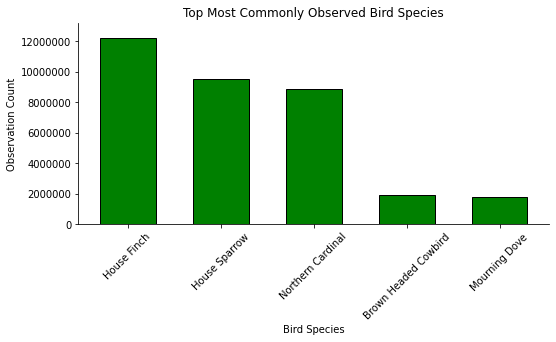

In [8]:
X_AMOUNT = 5

top_species = species_counts.head(X_AMOUNT)

plot = top_species.hvplot.bar(
    color='green',
    title='Top Most Commonly Observed Bird Species',
    xlabel='Bird Species',
    ylabel='Observation Count',
    yformatter='%.0f', # no scientific notation !!!!
    rot=45, 
    xticks=8, 
)

plot

We can see the House Finch and House Sparrow are the two most common birds by milestones. 

This shouldn't shock many, the Montana State Government even confirms House Finches have "a fondness for feeding stations". [[3]](https://fieldguide.mt.gov/speciesDetail.aspx?elcode=ABPBY04040)

The Cornell Lab of Ornithology states:
* "If you haven't seen one recently, chances are you can find [the House Finch] at the next bird feeder you come across." [[4]](https://www.allaboutbirds.org/guide/House_Finch/overview) 

* "[House Sparrows] are frequent visitors to backyard feeders". [[5]](https://www.allaboutbirds.org/guide/House_Sparrow)

Let's confirm our data isn't bad or otherwise skewed and take a look at bird distribution with:

#### Question 2: What is the distribution of bird species?

*This question uses hvplot with a MatPlotLib backend, it has been broken into two cells. One for calculation, another for graphing.*

In [9]:
df['month'] = df['timestamp'].dt.month

# Group the data by 'month' and count occurrences
monthly_counts = df['month'].value_counts().compute().sort_index()

:Curve   [month]   (count)
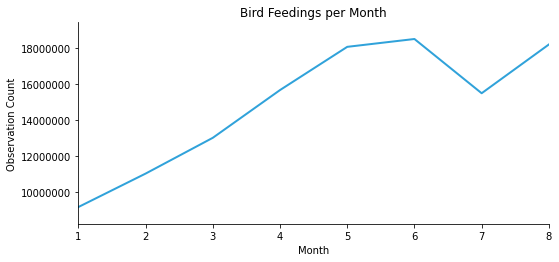

In [10]:
plot = monthly_counts.hvplot.line(
    title='Bird Feedings per Month',
    xlabel='Month', 
    ylabel='Observation Count',
    yformatter='%.0f' # no scientific notation !!!!
)

plot

We can see there seems to be a strange discrepancy in month 7, but that's okay.

#### Question 3: Where are the most popular regions to see bird (feeders)?

*From now on, we'll be using hvplot. It works directly with Dask, but will output Matplotlib graphs.*

In [11]:
sample = df.sample(frac=0.01).compute() # 1% of our data is a lot still, dw.

In [12]:
hvplot.output(backend='bokeh')

# matplotlib doesnt have support for "tiles"

plot = sample.hvplot.points(
    'anonymized_longitude',
    'anonymized_latitude',
    features=['borders', 'states'],
    geo=True,
    tiles=True,
    coastline=True,
    datashade=True,
    dynspread=True,
    #width=1920,
    #height=1080,
)

plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'4ceb8560-760b-4255-8253-82093424d4b0': {'version…

#### Question 4/5: Is there a correlation between the time of day and the number of bird sightings at feeders worldwide?

Double question! This required a lot of complex graphing and I'm considering it two questions.

First, let's even see what the number of feedings at a given time is.

In [14]:
from scipy.stats import pearsonr

df['hour'] = df['timestamp'].dt.hour

# Group data by hour and count observations
hourly_counts = df.groupby('hour').size().compute()

# Extract the 'hour' column from the Dask DataFrame
hour_column = df['hour']

:Curve   [hour]   (0)
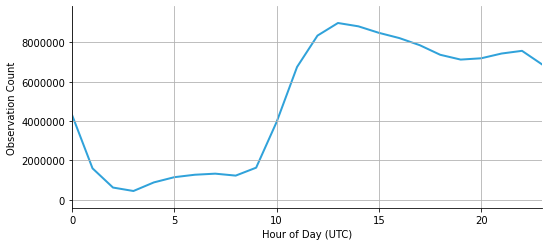

In [15]:
hvplot.output(backend='matplotlib')

plot = hourly_counts.hvplot.line(
    title='',
    xlabel='Hour of Day (UTC)', 
    ylabel='Observation Count',
    grid=True,
    yformatter='%.0f' # no scientific notation !!!!
)

plot

Let's regenerate this graph with CST.

:Curve   [hour]   (0)
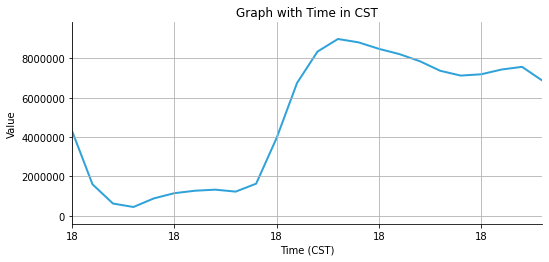

In [33]:
import pytz

def cstify(timestamp_utc):
    cst = pytz.timezone('US/Central')
    tz = pd.Timestamp(timestamp_utc)
    return tz.tz_localize('UTC').tz_convert(cst).strftime("%H")

plot = hourly_counts.hvplot.line(
    title='Graph with Time in CST',
    xlabel='Time (CST)', 
    ylabel='Value',
    grid=True,
    xformatter=cstify,
    yformatter='%.0f', # no scientific notation !!!!
)

plot

We don't see a linear correlation in the traditional definition. I've never taken a stats class a day in my life, so I may not be an expert we do see changes following America-centric timezones. Bird Buddy as a primarily American Customerbase gets most of it's traffic during American daytime hours.

#### Question 6: How does the distribution of bird species vary with respect to latitude? 

In [ ]:
# Step 2: Calculate species counts by latitude
species_counts = sample.groupby('anonymized_latitude')['species_name'].nunique().reset_index()

In [38]:
# Step 3: Create an interactive scatter plot using hvplot
scatter_plot = species_counts.hvplot.scatter(
    x='anonymized_latitude', y='species_name', title='Bird Species Distribution with Respect to Latitude',
    xlabel='Latitude', ylabel='Number of Unique Bird Species',
    grid=True, height=400, width=600, legend=False
)

scatter_plot

2023-10-04 05:07:53,851 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-10-04 05:07:57,108 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
Task exception was never retrieved
future: <Task finished name='Task-717825' coro=<Client._gather.<locals>.wait() done, defined at /home/dj/school/acs2500/.venv/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dj/school/acs2500/.venv/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-717826' coro=<Client._gather.<locals>.wait() done, defined at /home/dj/school/acs2500/.venv/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dj/school/acs2500/.ve

KeyboardInterrupt: 

---

## Conclusion

I have never done a day of data science in my life, nor do I have any interest in birds. I learned a lot in my efforts to analyze **BIG DATA** and it's that this is not for me at all. 

Most of the data is as expected, it was never my intention to discover anything new but rather show off trends we mostly could've guessed. I'm happy to have done it and the challenge has kept me up later than I'd like to admit twice.  

## Appendix

Please see `generate.py` for how this data was collected.

## Citations

A huge thank you to everything I used to write this.

* [Dask DataFrame](https://docs.dask.org/en/stable/dataframe.html)
* [Dask GeoPandas](https://dask-geopandas.readthedocs.io/en/stable/index.html)
* [hvplot's documentation](https://hvplot.holoviz.org/index.html)
* [geopandas' documentation as well](https://geopandas.org/en/stable/index.html)
* [BirdBuddy for hosting the data in the first place](https://live.mybirdbuddy.com/)
* [OpenAI's ChatGPT](https://chat.openai.com)
  - I was curious what it was like to use AI to assist with a large project. It was bad. I do not recommend it. AI cannot remember anything and I feel like I spent a lot of time cleaning up after it. However it did help to launch new ideas and write complex passages. Excluding this one! 

As well as any links sourced inline like so[100].